In [738]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [739]:
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [740]:
# Create an instance of the exchange
exchange = ccxt.binance()

# Fetch OHLCV (Open, High, Low, Close, Volume) data for BTC/EUR pair
ohlcv = exchange.fetch_ohlcv('BTC/EUR', timeframe='1d')

In [741]:
df_ohlcv = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

In [742]:
df_ohlcv['date'] = df_ohlcv['date'].apply(lambda x: datetime.fromtimestamp(x/1000))

In [743]:
df_ohlcv.head()

,date,open,high,low,close,volume
0,2022-08-18 02:00:00,22951.65,23243.99,22884.26,22995.57,1286.73047
1,2022-08-19 02:00:00,22995.57,23020.50,20722.59,20767.64,3488.47690
2,2022-08-20 02:00:00,20773.58,21314.58,20701.61,21084.10,1366.78896
3,2022-08-21 02:00:00,21082.05,21760.00,21021.31,21479.32,1427.75388
4,2022-08-22 02:00:00,21480.29,21695.67,20915.95,21524.51,1860.73959


In [744]:
df_ohlcv.describe()

,date,open,high,low,close,volume
count,500,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2023-04-24 13:34:55.200000,24453.031040,24872.664700,24062.979580,24483.526060,1641.918476
min,2022-08-18 02:00:00,15387.420000,15487.350000,15120.000000,15379.210000,88.261530
25%,2022-12-20 19:00:00,20202.550000,20555.290000,19775.677500,20204.750000,492.972408
50%,2023-04-24 14:00:00,24667.215000,24975.955000,24158.445000,24678.055000,1059.304750
75%,2023-08-27 08:00:00,26841.077500,27154.992500,26598.510000,26856.282500,2357.868103
max,2023-12-30 01:00:00,41123.350000,41574.460000,40561.590000,41109.830000,11341.142750
std,NaN,5872.118841,5978.749687,5770.669788,5904.020639,1613.451343


In [745]:
# Filter the DataFrame to start at the specific date
df_ohlcv_year = df_ohlcv[df_ohlcv['date'] >= df_ohlcv['date'].max() - timedelta(days=365)]

In [746]:
df_ohlcv_year.describe()

,date,open,high,low,close,volume
count,366,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2023-06-30 13:35:34.426229248,26569.883169,27032.260137,26166.423825,26631.552131,1205.022702
min,2022-12-30 01:00:00,15425.080000,15487.350000,15306.590000,15425.260000,88.261530
25%,2023-03-31 08:00:00,24151.220000,24343.855000,23870.830000,24153.047500,419.065575
50%,2023-06-30 14:00:00,25792.950000,26238.795000,25385.920000,25796.695000,729.537860
75%,2023-09-29 20:00:00,27686.327500,28125.982500,27295.100000,27705.872500,1360.949332
max,2023-12-30 01:00:00,41123.350000,41574.460000,40561.590000,41109.830000,7990.789180
std,NaN,5357.000373,5445.977821,5234.670071,5360.851607,1306.173255


In [747]:
df_year = df_ohlcv_year['open'].values

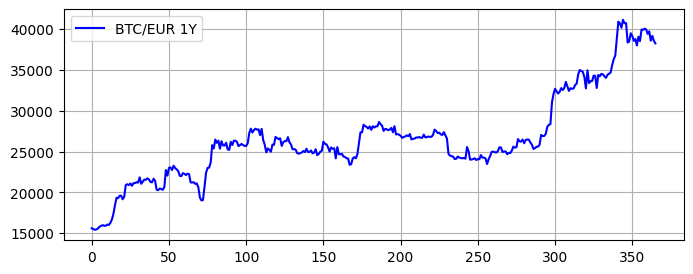

In [748]:
plt.figure(figsize=(8,3))
plt.plot(df_year, color='blue', label='BTC/EUR 1Y')
plt.grid()
plt.legend();

In [749]:
df = df_ohlcv['open'].values
df = df.reshape(-1, 1)

In [750]:
# test train split
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

In [751]:
# scaling data
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [752]:
def create_custom_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [753]:
x_train, y_train = create_custom_dataset(dataset_train)
x_test, y_test = create_custom_dataset(dataset_test)

In [754]:
y_train.shape, y_test.shape

((350,), (100,))

In [755]:
x_train.shape, x_test.shape

((350, 50), (100, 50))

In [756]:
x_train[0]

array([0.57175349, 0.57507324, 0.40712085, 0.43043701, 0.46053857,
       0.46444034, 0.47037237, 0.4589059 , 0.47174729, 0.37585073,
       0.35971452, 0.32704681, 0.37084992, 0.33234693, 0.34773331,
       0.36489976, 0.35355801, 0.34382322, 0.36113555, 0.342022  ,
       0.27345448, 0.29723021, 0.2967714 , 0.4418294 , 0.46352499,
       0.47359009, 0.50845737, 0.36648254, 0.36917644, 0.33001962,
       0.33342026, 0.35683695, 0.3026286 , 0.31028777, 0.2688815 ,
       0.25707489, 0.32656305, 0.33944828, 0.31157728, 0.3044336 ,
       0.34746347, 0.34022758, 0.34860331, 0.34343547, 0.33548982,
       0.32741038, 0.30902775, 0.34577713, 0.37712889, 0.37419765])

In [757]:
x_train[1]

array([0.57507324, 0.40712085, 0.43043701, 0.46053857, 0.46444034,
       0.47037237, 0.4589059 , 0.47174729, 0.37585073, 0.35971452,
       0.32704681, 0.37084992, 0.33234693, 0.34773331, 0.36489976,
       0.35355801, 0.34382322, 0.36113555, 0.342022  , 0.27345448,
       0.29723021, 0.2967714 , 0.4418294 , 0.46352499, 0.47359009,
       0.50845737, 0.36648254, 0.36917644, 0.33001962, 0.33342026,
       0.35683695, 0.3026286 , 0.31028777, 0.2688815 , 0.25707489,
       0.32656305, 0.33944828, 0.31157728, 0.3044336 , 0.34746347,
       0.34022758, 0.34860331, 0.34343547, 0.33548982, 0.32741038,
       0.30902775, 0.34577713, 0.37712889, 0.37419765, 0.37790063])

In [758]:
x_train[1][-1] == y_train[0]

True

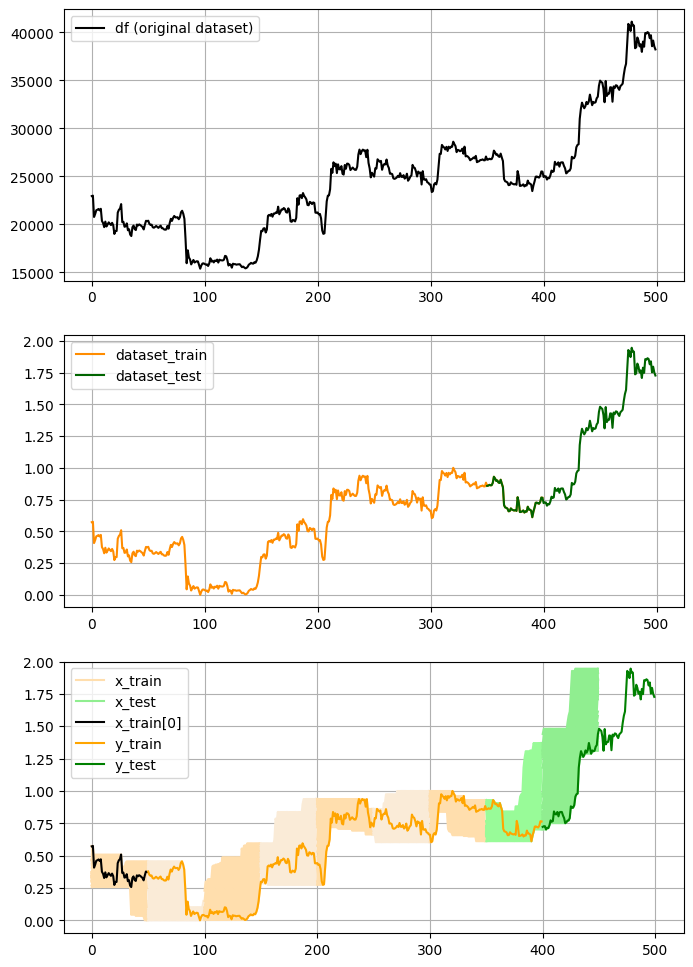

In [759]:
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
ax[0].plot(df, color='black', label='df (original dataset)')
ax[0].grid()
ax[0].legend();

ax[1].plot(dataset_train, color='darkorange', label='dataset_train')
ax[1].plot(range(350, 500), dataset_test, color='darkgreen', label='dataset_test')
ax[1].grid()
ax[1].legend();

ax[2].plot(x_train[0:50], color='navajowhite')
ax[2].plot(range(50, 100), x_train[50:100], color='antiquewhite')
ax[2].plot(range(100, 150), x_train[100:150], color='navajowhite')
ax[2].plot(range(150, 200), x_train[150:200], color='antiquewhite')
ax[2].plot(range(200, 250), x_train[200:250], color='navajowhite')
ax[2].plot(range(250, 300), x_train[250:300], color='antiquewhite')
ax[2].plot(range(300, 350), x_train[300:350], color='navajowhite')
        
ax[2].plot(x_train[0], color='navajowhite', label='x_train')  # label
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+50), x_test[0], color='lightgreen', label='x_test')  # label
ax[2].plot(x_train[0], color='black', label='x_train[0]')
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+int(y_test.shape[0]*0.5)), x_test[0:50], color='palegreen')
ax[2].plot(range(y_train.shape[0]+int(y_test.shape[0]*0.5), y_train.shape[0]+y_test.shape[0]), x_test[50:100], color='lightgreen')
ax[2].plot(range(50, y_train.shape[0]+50), y_train, color='orange', label='y_train')
ax[2].plot(range(y_train.shape[0]+50, y_train.shape[0]+y_test.shape[0]+50), y_test, color='green', label='y_test')
ax[2].set_xlim(-25, y_train.shape[0]+y_test.shape[0]+50+25)
ax[2].set_ylim(-0.1, 2)
ax[2].grid();
ax[2].legend();

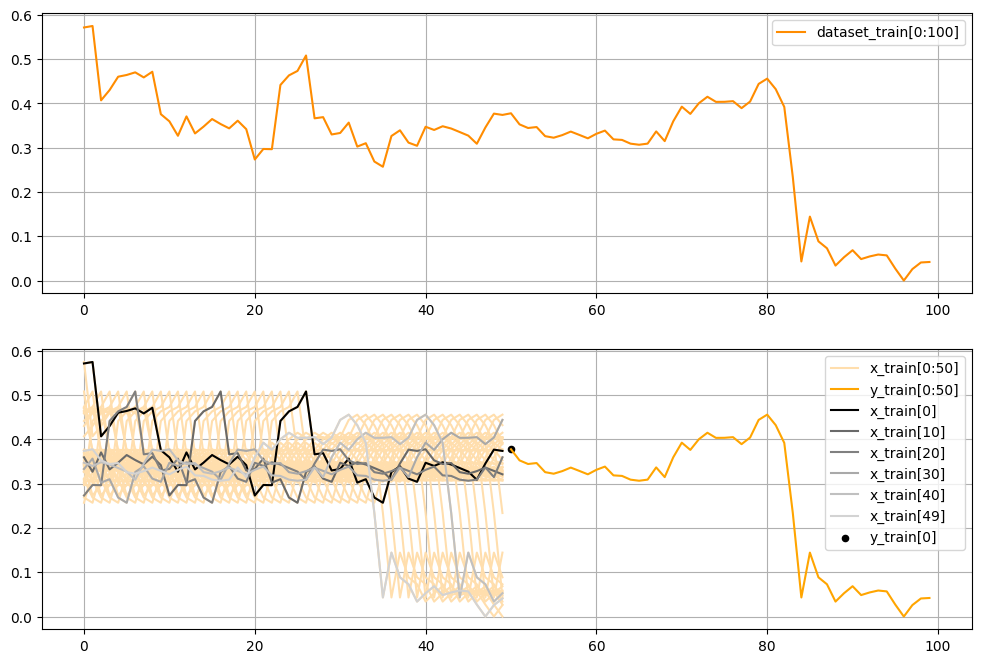

In [760]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_train[0], color='darkorange', label='dataset_train[0:100]')  # label
ax[0].plot(dataset_train[0:100], color='darkorange')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_train[0], color='navajowhite', label='x_train[0:50]')  # label
ax[1].plot(x_train[0:50], color='navajowhite')
ax[1].plot(range(50, 100), y_train[0:50], color='orange', label='y_train[0:50]')
ax[1].plot(x_train[0], color='black', label='x_train[0]')
ax[1].plot(x_train[10], color='dimgrey', label='x_train[10]')
ax[1].plot(x_train[20], color='grey', label='x_train[20]')
ax[1].plot(x_train[30], color='darkgrey', label='x_train[30]')
ax[1].plot(x_train[40], color='silver', label='x_train[40]')
ax[1].plot(x_train[49], color='lightgrey', label='x_train[49]')
ax[1].scatter(50, y_train[0], label='y_train[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

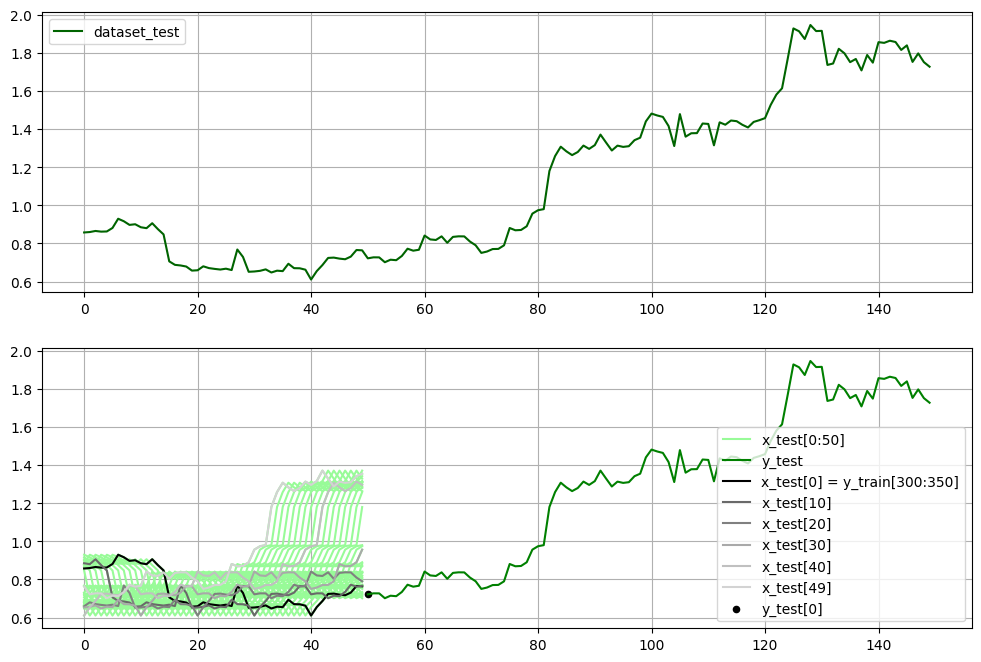

In [761]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_test[0], color='darkgreen', label='dataset_test')  # label
ax[0].plot(dataset_test, color='darkgreen')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_test[0], color='palegreen', label='x_test[0:50]')  # label
ax[1].plot(x_test[0:50], color='palegreen')
ax[1].plot(range(50, 150), y_test, color='green', label='y_test')
ax[1].plot(x_test[0], color='black', label='x_test[0] = y_train[300:350]')
ax[1].plot(x_test[10], color='dimgrey', label='x_test[10]')
ax[1].plot(x_test[20], color='grey', label='x_test[20]')
ax[1].plot(x_test[30], color='darkgrey', label='x_test[30]')
ax[1].plot(x_test[40], color='silver', label='x_test[40]')
ax[1].plot(x_test[49], color='lightgrey', label='x_test[49]')
ax[1].scatter(50, y_test[0], label='y_test[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

In [762]:
# reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(350, 50, 1)
(100, 50, 1)


In [763]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [764]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50, 96)            37632     
                                                                 
 dropout_18 (Dropout)        (None, 50, 96)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50, 96)            74112     
                                                                 
 dropout_19 (Dropout)        (None, 50, 96)            0         
                                                                 
 lstm_20 (LSTM)              (None, 96)                74112     
                                                                 
 dropout_20 (Dropout)        (None, 96)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [765]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [766]:
if not os.path.exists('models/bitcoin_eur_prediction.keras'):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('models/bitcoin_eur_prediction.keras')

In [767]:
model = load_model('models/bitcoin_eur_prediction.keras')

In [768]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # inverse MinMaxScaler()

# Make forecast
future_steps = 30
forecast = []
input_data = x_test[-1]

for _ in range(future_steps):
    input_data = input_data.reshape((1, 50, 1))
    prediction = model.predict(input_data, verbose=0)
    forecast.append(prediction[0, 0])
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

forecast_inversed = scaler.inverse_transform(np.array(forecast).reshape((future_steps, 1)))
print("Forecasted values:\n", forecast_inversed)

4/4 [==============================] - 1s 17ms/step
Forecasted values:
 [[36665.77 ]
 [35878.355]
 [34905.703]
 [34036.293]
 [33346.977]
 [32841.47 ]
 [32501.709]
 [32299.877]
 [32202.29 ]
 [32172.838]
 [32176.584]
 [32182.943]
 [32168.146]
 [32116.64 ]
 [32021.357]
 [31882.812]
 [31707.463]
 [31505.508]
 [31288.77 ]
 [31068.799]
 [30855.559]
 [30656.617]
 [30476.867]
 [30318.56 ]
 [30181.727]
 [30064.598]
 [29964.184]
 [29876.854]
 [29798.773]
 [29726.338]]


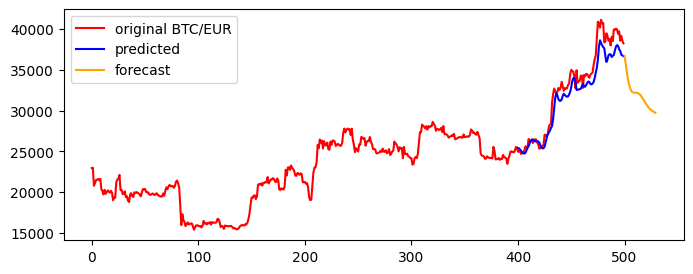

In [769]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(df, color='red', label='original BTC/EUR')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='blue', label='predicted')
plt.plot(range(len(df), len(df)+future_steps), forecast_inversed, color = 'orange', label='forecast')
plt.legend();

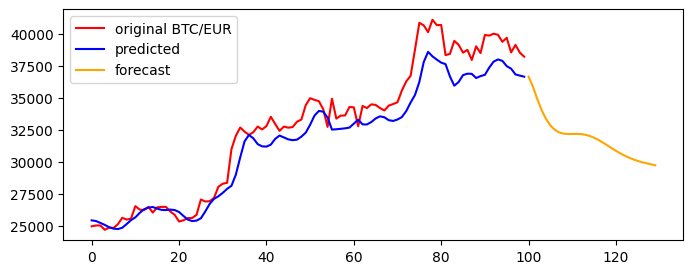

In [770]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(y_test_scaled, color='red', label = 'original BTC/EUR')
plt.plot(predictions, color = 'blue', label='predicted')
plt.plot(range(100, 100+future_steps), forecast_inversed, color = 'orange', label='forecast')
plt.legend();

In [778]:
today = datetime.today()
next_day = today + timedelta(days=1)
one_week = today + timedelta(days=7)
one_month = today + timedelta(days=30)
today_value = df[-1][0]
next_day_forcasted_value = forecast_inversed[0][0]
one_week_forcasted_value = forecast_inversed[6][0]
one_month_forcasted_value = forecast_inversed[29][0]
change_value = np.abs(today_value - next_day_forcasted_value)
change_description = 'FALL' if today_value > next_day_forcasted_value else 'RISE'
message = f"""
BTC/EUR

TODAY      ({today.date()}): {today_value} EUR

FORECASTED ({next_day.date()}): {next_day_forcasted_value:.2f} EUR
           ({one_week.date()}): {one_week_forcasted_value:.2f} EUR
           ({one_month.date()}): {one_month_forcasted_value:.2f} EUR

TOMMORROW {change_description}: {change_value:.2f} EUR
"""
print(message)


BTC/EUR

TODAY      (2023-12-30): 38230.31 EUR

FORECASTED (2023-12-31): 36665.77 EUR
           (2024-01-06): 32501.71 EUR
           (2024-01-29): 29726.34 EUR

TOMMORROW FALL: 1564.54 EUR

